### Spectrogram / Audio model

This notebook contains  code for the audio model. A model containing 3 Convolution
Neural Networks (CNNs) was used with account to limited compute in time of training.

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# augmentations to the data in a format that
# can be used by the model
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {'train': datasets.ImageFolder("../../data/train/spectrogram/",
                                          data_transforms['train']),
                  'val': datasets.ImageFolder("../../data/validation/spectrogram/",
                                          data_transforms['val']),
                  'test': datasets.ImageFolder("../../data/test/spectrogram/",
                                              data_transforms['val'])
                 }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

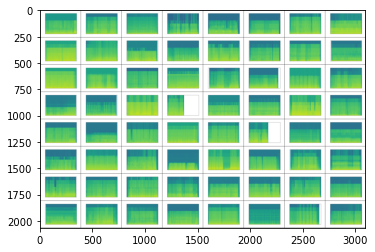

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
training_losses = []
valid_losses = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                training_losses.append(running_loss)
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                valid_losses.append(running_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
# transfer learning
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.05)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [6]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------


/home/martinoywa/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 9.3137 Acc: 0.2722
val Loss: 4.8185 Acc: 0.2665

Epoch 1/49
----------
train Loss: 2.2717 Acc: 0.3345
val Loss: 1.7078 Acc: 0.3042

Epoch 2/49
----------
train Loss: 1.7588 Acc: 0.3915
val Loss: 2.5210 Acc: 0.2594

Epoch 3/49
----------
train Loss: 2.1055 Acc: 0.3407
val Loss: 2.7696 Acc: 0.2901

Epoch 4/49
----------
train Loss: 2.2658 Acc: 0.3642
val Loss: 3.6673 Acc: 0.2075

Epoch 5/49
----------
train Loss: 2.1665 Acc: 0.3531
val Loss: 3.0655 Acc: 0.2689

Epoch 6/49
----------
train Loss: 2.3116 Acc: 0.3359
val Loss: 2.2683 Acc: 0.2807

Epoch 7/49
----------
train Loss: 1.2951 Acc: 0.4902
val Loss: 1.5961 Acc: 0.3750

Epoch 8/49
----------
train Loss: 1.1630 Acc: 0.5069
val Loss: 1.6532 Acc: 0.3349

Epoch 9/49
----------
train Loss: 1.1479 Acc: 0.5170
val Loss: 1.5828 Acc: 0.3538

Epoch 10/49
----------
train Loss: 1.1240 Acc: 0.5232
val Loss: 1.5380 Acc: 0.3325

Epoch 11/49
----------
train Loss: 1.1271 Acc: 0.5213
val Loss: 1.5682 Acc: 0.3396

Epoch 12/49
----------
t

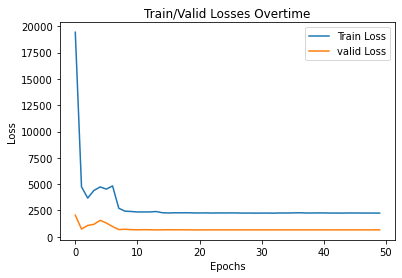

In [10]:
plt.plot(training_losses, label="Train Loss")
plt.plot(valid_losses, label="valid Loss")
plt.title("Train/Valid Losses Overtime")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Train Val with lr 0.05.png")

In [11]:
# save model
torch.save(model_conv.state_dict(), f"finetuned_Frozen-RESNET_model.lr.0.05.pt")

In [12]:
# load and test model
model_conv.load_state_dict(torch.load("finetuned_Frozen-RESNET_model.lr.0.05.pt", map_location="cpu"), strict=False)

<All keys matched successfully>

In [13]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model_conv.cpu()
model_conv.eval() # prep model for *evaluation*

for data, target in dataloaders['test']:
    batch_size = data.size(0)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model_conv(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(dataloaders['test'].dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.515187

Test Accuracy of     0: 54% (185/340)
Test Accuracy of     1: 24% (50/206)
Test Accuracy of     2: 44% (119/265)
Test Accuracy of     3: 27% (56/201)

Test Accuracy (Overall): 40% (410/1012)
